In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

# import libraries:
import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np
import git
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
# import tension tools utilities:
from tensiometer import utilities


def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

2024-12-02 09:49:08.021209: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:49:08.095494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:49:08.096520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 09:49:08.957467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import cosmological data

In [2]:
# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))
os.chdir('/home/matias/montepython_public/output')

#Fixed Parameters
num_parameters = 2
num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples.loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='old_metrics/lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})

param_names = ['Omega_m','H0'] #Shared paameters

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)

In [3]:
#Get the gaussian approximations
os.chdir(os.path.join(path_git))
from tensiometer import gaussian_tension
gaussian_A = gaussian_tension.gaussian_approximation(chain_A)
gaussian_B = gaussian_tension.gaussian_approximation(chain_B)
gaussian_C = gaussian_tension.gaussian_approximation(chain_C)
gaussian_D = gaussian_tension.gaussian_approximation(chain_D)

# Anova-like stimators

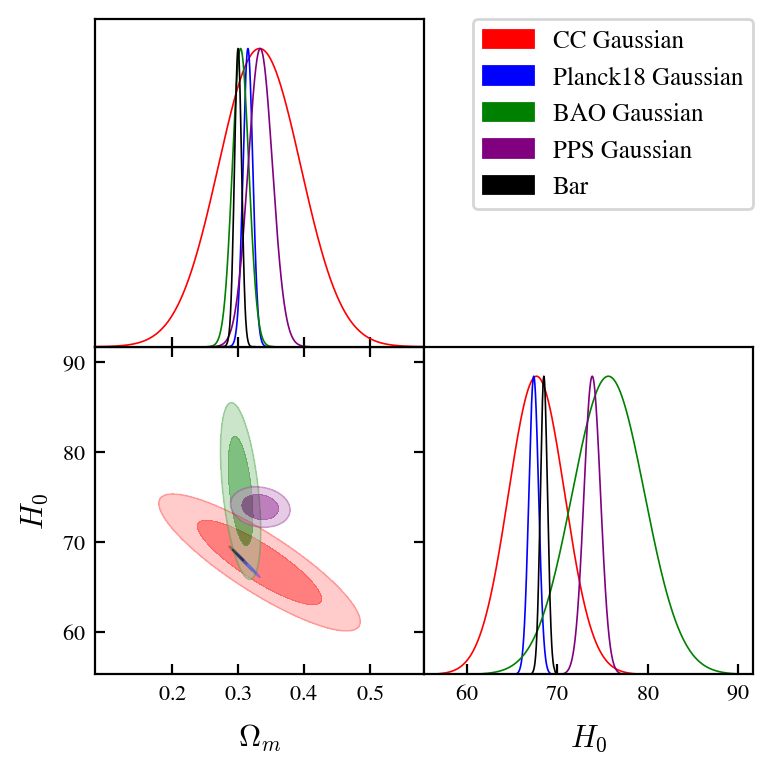

In [4]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C + cov_D
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C, mean_D], [cov_A, cov_B, cov_C, cov_D])
mean_bar = centroid
cov_bar = centroid_covariance

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=param_names, labels=param_names, label='Bar')
colors = ['red', 'blue', 'green', 'purple', 'black']

g = plots.get_subplot_plotter()
g.triangle_plot([gaussian_A,gaussian_B,gaussian_C,gaussian_D, chain_bar], params=param_names,\
                legend_labels=['CC Gaussian','Planck18 Gaussian','BAO Gaussian','PPS Gaussian','Bar'],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
#g.export('figures_matrix_tension/contour_guassian.pdf')
plt.savefig('triangle_plot_data_centroid.pdf')

delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar
delta_theta_D = mean_D - mean_bar

## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

In [5]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

print(r'alpha: {}'.format(alpha))


# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= alpha)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''

PTE = samp_chi2[samp_chi2 > alpha].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


alpha: 6.081778470204801
[8.82824497e-01 1.37724681e-01 2.27943680e-02 4.47252836e-04
 3.70467966e-02 7.95668274e-01 1.20197204e-01 3.60784246e-02]
(1000000, 8)
[[ 0.22615741  0.86013792  2.15903008 ...  0.64202113  4.71566055
   0.98235819]
 [ 2.79759452  0.10396685  0.54129371 ...  0.64873111  0.29843439
   0.50362277]
 [ 0.03404543  0.29367719  4.86660879 ...  1.95073018  0.99756688
   0.05338098]
 ...
 [ 1.04538255  1.01421454  4.93445891 ...  0.5678634   2.91443287
   0.25741239]
 [ 0.40218185  0.05745785  0.45030531 ...  0.03507916  1.5738671
   0.66743948]
 [ 0.23340409 19.48823049  0.02500676 ...  1.10799689  1.81365843
   0.33655253]]
PTE: 0.033425
n_sigma: 2.12694
PTE: 0.083824
n_sigma: 1.72892


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

In [6]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))) \
     + np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))) \
     + np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))) \
     + np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D)))


print(r'beta: {}'.format(beta))

df=num_datasets*num_parameters
PTE = chi2.sf(beta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > beta].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 64.98853419215975
PTE: 4.85134489788294e-11
n_sigma: 6.57543
PTE: 0.0
n_sigma:   inf


In [7]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\beta$:')
print('CC+Planck18:', np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))))
print('CC+BAO:',np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))))
print('Planck18+BAO:',np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))))
print('CC+PPS:',np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))))
print('Planck18+PPS:',np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))))
print('BAO+PPS:',np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D))))

Diferentes términos de $\beta$:
CC+Planck18: 0.5381290661527516
CC+BAO: 2.7890147929266145
Planck18+BAO: 4.198605436052179
CC+PPS: 10.382340622752869
Planck18+PPS: 45.28306372417381
BAO+PPS: 1.7973805501015165


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

In [8]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D))

print(r'gamma: {}'.format(gamma))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= gamma)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 
'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''
PTE = samp_chi2[samp_chi2 >= gamma].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

gamma: 50.64708973159805
[8.82824497e-01 1.37724681e-01 2.27943680e-02 4.47252836e-04
 3.70467966e-02 7.95668274e-01 1.20197204e-01 3.60784246e-02]
(1000000, 8)
[[8.29063235e-01 2.92089499e-01 1.31845609e+00 ... 4.72832103e-01
  2.09638952e+00 2.08383220e+00]
 [5.06295093e-01 1.08749591e-01 4.35667992e-02 ... 6.40936058e-02
  2.36480831e+00 8.27459429e-01]
 [1.19802205e+00 3.30478372e+00 1.62677097e-01 ... 2.96361629e-02
  1.67694135e+00 8.99206644e-01]
 ...
 [2.36965432e+00 1.40778669e+00 2.84672571e+00 ... 3.78453323e-02
  2.13641926e+00 3.03619017e+00]
 [3.22912369e-03 2.18672562e-02 1.30865584e-01 ... 6.60031537e-02
  8.68859809e-01 2.13719940e-01]
 [1.84358060e+00 1.44614485e+00 1.37742257e-02 ... 2.75191146e+00
  1.83917350e+00 1.03986706e-03]]
PTE: 0.0
n_sigma:   inf
PTE: 1e-06
n_sigma: 4.89164


In [9]:

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''
print(r'Diferentes términos de $\gamma$:')
print('CC:', np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)))
print('Planck18:',np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)))
print('BAO:',np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C)))
print('PPS:',np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D), delta_theta_D)))

Diferentes términos de $\gamma$:
CC: 0.4128103017580652
Planck18: 4.4013883522360615
BAO: 4.754065885769752
PPS: 41.07882519183417


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

In [10]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C)) \
      + np.dot(delta_theta_D.T,np.dot(A_matrix, delta_theta_D))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))
D_eigenval = np.linalg.eigvals(np.dot(cov_D+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval, D_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= delta)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + D_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1] + D_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * D_eigenval[1])
'''


PTE = samp_chi2[samp_chi2 > delta].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

[1.27534198e+03 5.36347662e+01 2.85917335e+00 2.00598215e+00
 5.92934023e+00 2.79681169e+03 4.76882787e+02 5.11584265e+00]
(1000000, 8)
[[1.54847839e+00 2.43603795e-01 2.04010977e+00 ... 2.99878652e-03
  2.78221679e-02 1.45493762e+00]
 [2.13525788e+00 7.17410191e-02 3.84741495e-02 ... 4.89407440e-02
  7.77184763e-02 3.15528878e+00]
 [1.07230125e+00 5.25623616e-01 9.50096515e-03 ... 5.55151378e-02
  2.59351092e-03 3.14921725e-01]
 ...
 [1.80024860e+00 2.76105769e-01 5.90390246e-01 ... 9.76796445e-01
  1.92063531e-01 2.75210885e-03]
 [4.33497485e+00 1.82323564e-01 2.10785351e-01 ... 2.92650480e+00
  3.12611491e+00 8.13403285e-01]
 [1.67368350e+00 2.47826885e+00 3.56539757e-02 ... 1.11053310e+00
  7.73985145e-01 7.32558391e-02]]
PTE: 0.005083
n_sigma: 2.80173
PTE: 0.021683
n_sigma: 2.29588


## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [11]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 45.981057637521204
PTE: 2.396783708931806e-07
n_sigma: 5.16559
PTE: 3.3e-07
n_sigma: 5.10545


## $\zeta$-stimator

\begin{equation}
    \zeta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j) + \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [12]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C)) \
        + np.dot(delta_theta_D.T,np.dot(np.linalg.inv(cov_D + cov_bar), delta_theta_D))

beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C))) \
     + np.dot((mean_A - mean_D).T, np.dot(np.linalg.inv(cov_A + cov_D), (mean_A - mean_D))) \
     + np.dot((mean_B - mean_D).T, np.dot(np.linalg.inv(cov_B + cov_D), (mean_B - mean_D))) \
     + np.dot((mean_C - mean_D).T, np.dot(np.linalg.inv(cov_C + cov_D), (mean_C - mean_D)))


zeta = beta + epsilon

print(r'beta: {}'.format(beta))
print(r'epsilon: {}'.format(epsilon))
print(r'zeta: {}'.format(zeta))

df=2*num_datasets*num_parameters
PTE = chi2.sf(zeta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 64.98853419215975
epsilon: 45.981057637521204
zeta: 110.96959182968095
PTE: 2.933462106420353e-16
n_sigma: 8.16071
